<a href="https://colab.research.google.com/github/nathanhawe/CSCI-264/blob/main/back_propogation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here's a description of the setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tabulate

training_data = [((0, 0), 0), ((0, 1), 1), ((1, 0), 1), ((1, 1), 0)]

# sigmoid function used in the forward pass
def sig(x):
  return 1 / (1 + np.exp(-x))

# derivative of the sigmoid function used in back propogation
def sig_der(x):
  return x * (1 - x)

# Squared Error
def loss2(r, y):
  return np.power((r - y),2)

def forward_pass(X,W,V):
  Z = [1,0,0]

  # calculate the hidden layer skipping the bias (z0) which will remain unchanged
  Z[1] = sig((W[0][0] * X[0]) + (W[0][1] * X[1]) + (W[0][2] * X[2]))
  Z[2] = sig((W[1][0] * X[0]) + (W[1][1] * X[1]) + (W[1][2] * X[2]))

  # Calculate the output Y
  y = sig(np.dot(Z, V))

  return (Z, y)

def classify(x):
  return 1 if x >= 0.5 else 0

def print_W(W):
  for z in range(len(W)):
    for x in range(len(W[z])):
      print(f"w({z+1},{x}): {W[z,x]}")

def print_V(V):
  for z in range(len(V)):
    print(f"v(1,{z}): {V[z]}")

def print_stats(stats):
  seed = str(stats['seed'])
  print(f"Data from training with seed #{seed}:")
  print(f"Learning Rate: {stats['learning_rate']}")
  print(f"Starting Weights:")
  print_W(stats['starting_weight']['W'])
  print_V(stats['starting_weight']['V'])

  print("\nFinal Weights:")
  print_W(stats['final_weight']['W'])
  print_V(stats['final_weight']['V'])

  print("\nError and Accuracy at Epoch")
  print(tabulate.tabulate(stats['epoch'],headers='keys'))

  x = [e['epoch_num'] for e in stats['epoch']]
  y = [e['mse'] for e in stats['epoch']]
  plt.plot(x, y)
  plt.xlabel('EPOCH')
  plt.ylabel('MSE')
  plt.title(f'Error Over Time (Seed #{seed})')
  plt.show()

def run_set(seed, learning_rate = 0.02, max_epochs = 1000000, stat_interval = 1000):
  # seed RNG to ensure consistent results between runs
  np.random.seed(seed)

  # randomly generate starting weights (-0.01, 0.01)
  W = np.random.uniform(-0.01, 0.01, (2, 3))
  V = np.random.uniform(-0.01, 0.01, 3)

  stats = {
      'seed': seed,
      'learning_rate': learning_rate,
      'starting_weight': {
          'W': W.copy(),
          'V': V.copy()
      },
      'final_weight': {
          'W': [],
          'V': []
      },
      'epoch': []
  }

  for epochi in range(max_epochs):
    # Train
    for input in training_data:
      # prepending an additional input for bias X0
      X = [1] + [x for x in input[0]]
      r = input[1]

      # calculate the forward pass getting the hidden layer values and
      # output for use in back propogation
      (Z, y) = forward_pass(X, W, V)

      # calculate difference for V and W weights
      delta_V = [learning_rate * (r - y) * z for z in Z]
      delta_W = []
      for zi in range(1, len(W) + 1):
        temp = []
        for xi in range(len(W[zi-1])):
          temp.append(learning_rate * (r - y) * V[zi] * sig_der(Z[zi]) * X[xi])
        delta_W.append(temp)

      # apply difference to V and W
      for i in range(len(V)):
        V[i] += delta_V[i]

      for i in range(len(W)):
        for j in range(len(W[i])):
          W[i][j] += delta_W[i][j]

    # Measure the mean squared error and accuracy at regular intervals
    if epochi % stat_interval == 0 or epochi + 1 == max_epochs:
      count = 0
      success = 0
      total_error = 0
      for input in training_data:
        X = [1] + [x for x in input[0]]
        r = input[1]

        (_, y) = forward_pass(X, W, V)

        count += 1
        total_error += loss2(r, y)
        success += 1 if r == classify(y) else 0

      stats['epoch'].append({
        'epoch_num': (epochi + 1),
        'mse': total_error / count,
        'accuracy': success / count
      })

      # break early when accuracy is 1
      if success == count:
        break

  stats['final_weight']['W'] = W.copy()
  stats['final_weight']['V'] = V.copy()

  return stats


Batch

In [2]:
def run_batch_set(seed, learning_rate = 0.02, max_epochs = 1000000, stat_interval = 1000):
  # seed RNG to ensure consistent results between runs
  np.random.seed(seed)

  # randomly generate starting weights (-0.01, 0.01)
  W = np.random.uniform(-0.01, 0.01, (2, 3))
  V = np.random.uniform(-0.01, 0.01, 3)

  stats = {
      'seed': seed,
      'learning_rate': learning_rate,
      'starting_weight': {
          'W': W.copy(),
          'V': V.copy()
      },
      'final_weight': {
          'W': [],
          'V': []
      },
      'epoch': []
  }

  for epochi in range(max_epochs):
    # Train
    count = 0
    total_error = 0
    for input in training_data:
      # prepending an additional input for bias X0
      X = [1] + [x for x in input[0]]
      r = input[1]

      # calculate the forward pass getting the hidden layer values and
      # output to calculate mean error for use in back propogation
      (Z, y) = forward_pass(X, W, V)
      count += 1
      total_error += (r - y)

    mean_error = total_error/count

    # calculate difference for V and W weights
    delta_V = [learning_rate * (mean_error) * z for z in Z]
    delta_W = []
    for zi in range(1, len(W) + 1):
      temp = []
      for xi in range(len(W[zi-1])):
        temp.append(learning_rate * (mean_error) * V[zi] * sig_der(Z[zi]) * X[xi])
      delta_W.append(temp)

    # apply difference to V and W
    for i in range(len(V)):
      V[i] += delta_V[i]

    for i in range(len(W)):
      for j in range(len(W[i])):
        W[i][j] += delta_W[i][j]

    # Measure the mean squared error and accuracy at regular intervals
    if epochi % stat_interval == 0 or epochi + 1 == max_epochs:
      count = 0
      success = 0
      total_error = 0
      for input in training_data:
        X = [1] + [x for x in input[0]]
        r = input[1]

        (_, y) = forward_pass(X, W, V)

        count += 1
        total_error += loss2(r, y)
        success += 1 if r == classify(y) else 0

      stats['epoch'].append({
        'epoch_num': (epochi + 1),
        'mse': total_error / count,
        'accuracy': success / count
      })

      # break early when accuracy is 1
      if success == count:
        break

  stats['final_weight']['W'] = W.copy()
  stats['final_weight']['V'] = V.copy()

  return stats

Run #1

Data from training with seed #42:
Learning Rate: 0.02
Starting Weights:
w(1,0): -0.0025091976230527504
w(1,1): 0.009014286128198325
w(1,2): 0.0046398788362281024
w(2,0): 0.0019731696839407325
w(2,1): -0.006879627191151269
w(2,2): -0.006880109593275947
v(1,0): -0.00883832775663601
v(1,1): 0.007323522915498705
v(1,2): 0.002022300234864176

Final Weights:
w(1,0): 3.717182669195718
w(1,1): -2.6807148344941982
w(1,2): -2.6785928642168986
w(2,0): 1.7337632055862446
w(2,1): -5.577061602444532
w(2,2): -5.602682221748581
v(1,0): -1.883146954265725
v(1,1): 5.217906480896687
v(1,2): -6.8310497734184175

Error and Accuracy at Epoch
  epoch_num        mse    accuracy
-----------  ---------  ----------
          1  0.250001         0.5
       1001  0.25             0.5
       2001  0.25             0.5
       3001  0.25             0.75
       4001  0.25             0.75
       5001  0.25             0.75
       6001  0.25             0.75
       7001  0.25             0.75
       8001  0.25        

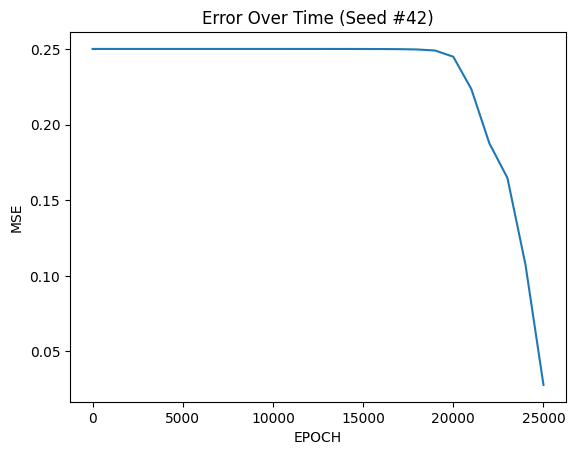

In [3]:
stats = run_set(42)
print_stats(stats)


Run #2

Data from training with seed #1:
Learning Rate: 0.02
Starting Weights:
w(1,0): -0.0016595599059485207
w(1,1): 0.004406489868843162
w(1,2): -0.009997712503653102
w(2,0): -0.003953348547363205
w(2,1): -0.00706488218365774
w(2,2): -0.008153228104624044
v(1,0): -0.006274795772446582
v(1,1): -0.0030887854591390455
v(1,2): -0.002064650515386601

Final Weights:
w(1,0): 3.142214702004801
w(1,1): -2.433026556591141
w(1,2): -2.4284932952699947
w(2,0): 1.6878899794196853
w(2,1): -7.700097687087125
w(2,2): -7.705370673374562
v(1,0): -1.4458303179601597
v(1,1): 4.832979974959006
v(1,2): -7.985860944779839

Error and Accuracy at Epoch
  epoch_num        mse    accuracy
-----------  ---------  ----------
          1  0.250005         0.5
       1001  0.25             0.5
       2001  0.25             0.5
       3001  0.25             0.5
       4001  0.25             0.5
       5001  0.25             0.5
       6001  0.25             0.5
       7001  0.25             0.75
       8001  0.249999       

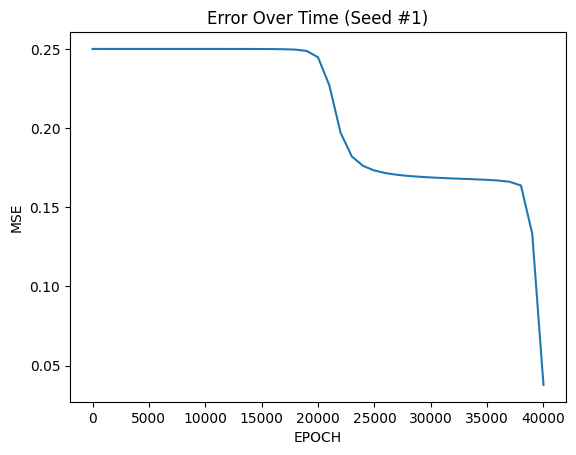

In [4]:
stats = run_set(1)
print_stats(stats)

Run #3

Data from training with seed #1085526:
Learning Rate: 0.09
Starting Weights:
w(1,0): -0.006515626201793645
w(1,1): 0.0064353380176404105
w(1,2): -0.006225746429910793
w(2,0): 0.007684464763440034
w(2,1): -0.009637659718220138
w(2,2): 0.005782798212053951
v(1,0): -0.003242289982140374
v(1,1): 0.003938052453540697
v(1,2): 0.009219850974545233

Final Weights:
w(1,0): 0.6332320890276966
w(1,1): -14.061760469741063
w(1,2): -14.08206580313773
w(2,0): 1.035999092995971
w(2,1): -14.62407009061742
w(2,2): -14.644375207448967
v(1,0): 0.662855317228237
v(1,1): -8.495634727024296
v(1,2): -10.077007559242363

Error and Accuracy at Epoch
  epoch_num       mse    accuracy
-----------  --------  ----------
          1  0.25            0.5
      50001  0.166827        0.75
     100001  0.166762        0.75
     150001  0.166741        0.75
     200001  0.166731        0.75
     250001  0.166724        0.75
     300001  0.16672         0.75
     350001  0.166718        0.75
     400001  0.166716        

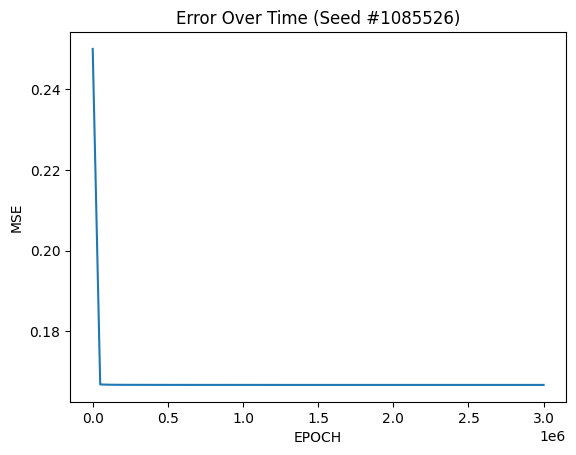

In [5]:
stats = run_set(1085526, learning_rate = 0.09, max_epochs=3000000, stat_interval=50000)
print_stats(stats)

# 0.166712 0.1
# 0.166947 0.25
# 0.167077 0.3
# 0.167419 0.4


Run #4

In [ ]:
stats = run_set(5, max_epochs=2000000, stat_interval=10000)
print_stats(stats)

Run #5

In [ ]:
stats = run_set(98, stat_interval=10000)
print_stats(stats)